# COVID19 CXR Dataset을 활용한 Transfer Learning

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = os.path.join(os.getenv('HOME'),'covid_data/CXR')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

In [4]:
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 12541
    Root location: /home/aiffel0042/covid_data/CXR/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 1400
    Root location: /home/aiffel0042/covid_data/CXR/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 1582
    Root location: /home/aiffel0042/covid_data/CXR/test
    StandardTransform
Transform: Compose(
          

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(type(dataset_sizes),end='\n\n')
print(dataset_sizes,end='\n\n')
print(dataset_sizes['train'])

<class 'dict'>

{'train': 12541, 'val': 1400, 'test': 1582}

12541


In [7]:
class_names = image_datasets['train'].classes
print(type(class_names))
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(type(device))
print(device)

<class 'list'>
['covid-19', 'normal', 'pneumonia']
<class 'torch.device'>
cuda:0


In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

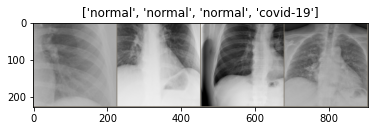

In [9]:
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
# model-> model , criterion -> loss function(Cross-Entropy), optimizer -> SGD , sheduler ->LR sheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #현재 시간 받아오기
    since = time.time()
    
    #model.state_dict()는 OrderedDict으로 model의 다양한 정보가 있음
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                #device gpu device설정
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파 계산
                        optimizer.step() # weight 최적화

                # 통계
                running_loss += loss.item() * inputs.size(0) # 평균 Loss에 batch size만큼 곱해준다!
                running_corrects += torch.sum(preds == labels.data) 
                # torch.sum -> 배치 4개를 하나씩 비교해서 더해줌 ex) 3개가 같으면 +3이 됨
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## Model

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
# transfer learnging
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len (class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Tensorboard

In [12]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('cxr_write')

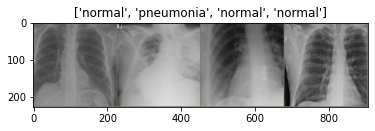

In [13]:
# 학습 데이터의 배치를 얻습니다.
images, labels = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
imshow(img_grid, title=[class_names[x] for x in labels])

# tensorboard에 기록합니다.
writer.add_image('COVID19 Test Data', img_grid)

In [14]:
images = images.to(device)

In [15]:
writer.add_graph(model_conv , images)
writer.close()

In [16]:
# 헬퍼 함수

def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다. 이는 신경망의 예측 결과 / 확률과 함께 정답을 보여주며,
    예측 결과가 맞았는지 여부에 따라 색을 다르게 표시합니다. "images_to_probs"
    함수를 사용합니다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과 / 정답과 함께 표시(plot)합니다
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6942 Acc: 0.7320
val Loss: 0.4732 Acc: 0.8257

Epoch 1/14
----------
train Loss: 0.6956 Acc: 0.7351
val Loss: 0.6459 Acc: 0.7821

Epoch 2/14
----------
train Loss: 0.6894 Acc: 0.7372
val Loss: 0.4251 Acc: 0.8386

Epoch 3/14
----------
train Loss: 0.6782 Acc: 0.7395
val Loss: 0.3541 Acc: 0.8821

Epoch 4/14
----------
train Loss: 0.6897 Acc: 0.7418
val Loss: 0.4270 Acc: 0.8657

Epoch 5/14
----------
train Loss: 0.6655 Acc: 0.7502
val Loss: 0.4016 Acc: 0.8593

Epoch 6/14
----------
train Loss: 0.6482 Acc: 0.7518
val Loss: 0.4516 Acc: 0.8321

Epoch 7/14
----------
train Loss: 0.5307 Acc: 0.7843
val Loss: 0.3494 Acc: 0.8721

Epoch 8/14
----------
train Loss: 0.5243 Acc: 0.7817
val Loss: 0.3237 Acc: 0.8843

Epoch 9/14
----------
train Loss: 0.5306 Acc: 0.7861
val Loss: 0.3269 Acc: 0.8807

Epoch 10/14
----------
train Loss: 0.5157 Acc: 0.7870
val Loss: 0.3359 Acc: 0.8750

Epoch 11/14
----------
train Loss: 0.5215 Acc: 0.7834
val Loss: 0.4696 Acc: 0.8229

Ep

## Class Activation Map

In [19]:
torch.__version__

'1.7.0'

In [21]:
save_path = os.path.join(os.getenv('HOME'),'github_project/pytorch/COVID-19_code/model')
torch.save(model_conv.state_dict(),save_path)

In [39]:
params = list(model_conv.parameters())

In [48]:
test = params[-2]
print(type(test))
test

<class 'torch.nn.parameter.Parameter'>


Parameter containing:
tensor([[-0.0806,  0.0528,  0.0097,  ..., -0.1712, -0.0813,  0.0183],
        [ 0.0661, -0.0826,  0.0985,  ...,  0.0408,  0.1339,  0.0330],
        [-0.0452,  0.0305, -0.0662,  ...,  0.1998,  0.0136, -0.0091]],
       device='cuda:0', requires_grad=True)

In [45]:
a = test.cpu().data.numpy()
print(type(a))
a.shape

<class 'numpy.ndarray'>


(3, 512)

In [49]:
weight_softmax = np.squeeze(a)
weight_softmax.shape
weight_softmax

array([[-0.08057629,  0.05284668,  0.00968315, ..., -0.17124999,
        -0.08131744,  0.01825829],
       [ 0.06614698, -0.0826172 ,  0.09848765, ...,  0.04080966,
         0.13387497,  0.03296346],
       [-0.04516725,  0.03052405, -0.06622571, ...,  0.19984193,
         0.01358177, -0.00909898]], dtype=float32)

In [50]:
test_model = model_conv
test_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
# 학습 데이터의 배치를 얻습니다.|
images, labels = next(iter(dataloaders['train']))

In [54]:
images = images.to(device)
labels = labels.to(device)
outputs = test_model(images)
_, preds = torch.max(outputs, 1)

In [60]:
outputs  = test_model(images)
outputs

tensor([[-5.9584,  4.1502, -0.0176],
        [-3.0860,  0.9268,  2.8371],
        [-3.6098,  3.7195,  1.1942],
        [-0.4158,  1.3976, -0.6032]], device='cuda:0', grad_fn=<AddmmBackward>)

In [61]:
verlay = params[-2][int(preds[0])].matmul(outputs[0].reshape(512,49)).reshape(7,7).cpu().data.numpy()

RuntimeError: shape '[512, 49]' is invalid for input of size 3

In [ ]:
params = list(net.parameters())
# get only weight from last layer(linear)
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (128, 128)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape( (nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam/np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

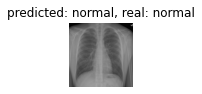

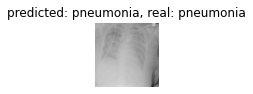

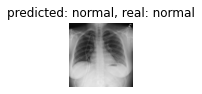

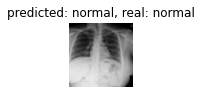

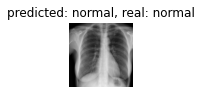

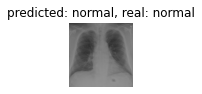

In [20]:
visualize_model(model_conv)

In [21]:
from collections import defaultdict
test = defaultdict(int)
a = {'tp':defaultdict(int),
     'fp':defaultdict(int),
     'fn':defaultdict(int),
     'total':0}
b = {x:defaultdict(int) for x in class_names}
b['total'] = 0
#print(b)

print(b['covid-19']['tp'])
#print(a['tp']['covid-19']['b'])

0


In [22]:
b = {x:defaultdict(int) for x in class_names}
b['total'] = defaultdict(int)
print(b)

{'covid-19': defaultdict(<class 'int'>, {}), 'normal': defaultdict(<class 'int'>, {}), 'pneumonia': defaultdict(<class 'int'>, {}), 'total': defaultdict(<class 'int'>, {})}


In [37]:
def test_acc(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]): # input.size 0 번째 : 배치 사이즈
                total +=1
                #print('predicted: {}, real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                if preds[j]==labels[j]:
                    correct+=1
    print('final test accuracy is {}%'.format(correct/total*100))

In [29]:
def test_measure(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                if labels[j] == preds[j]:
                    b[class_names[labels[j]]]['tp'] +=1
                    b['total']['correct']+=1
                else:
                    b[class_names[labels[j]]]['fn'] +=1
                    b[class_names[preds[j]]]['fp'] +=1
                    #b['total']['wrong']+=1
            b['total']['num']+=inputs.size()[0]
    #print precision , recall
    print('total accuracy: {}%'.format((b['total']['correct']/b['total']['num'])*100))
    print()
    #print covid precision , recall
    print('covid-19 precision: {}%'.format((b['covid-19']['tp']/(b['covid-19']['tp']+b['covid-19']['fp']))*100))
    print('covid-19 recall: {}%'.format((b['covid-19']['tp']/(b['covid-19']['tp']+b['covid-19']['fn']))*100))
    print()
    
    #print normal
    print('normal precision: {}%'.format((b['normal']['tp']/(b['normal']['tp']+b['normal']['fp']))*100))
    print('normal recall: {}%'.format((b['normal']['tp']/(b['normal']['tp']+b['normal']['fn']))*100))
    print()
    
    #print pneumonia
    print('pneumonia precision: {}%'.format((b['pneumonia']['tp']/(b['pneumonia']['tp']+b['pneumonia']['fp']))*100))
    print('pneumonia recall: {}%'.format((b['pneumonia']['tp']/(b['pneumonia']['tp']+b['pneumonia']['fn']))*100))

In [30]:
test_measure(model_conv)

total accuracy: 84.63969658659924%

covid-19 precision: 73.68421052631578%
covid-19 recall: 27.184466019417474%

normal precision: 85.0609756097561%
normal recall: 94.57627118644068%

pneumonia precision: 84.64285714285714%
pneumonia recall: 79.7979797979798%


In [38]:
test_acc(model_conv)

final test accuracy is 84.63969658659924%
